In [23]:
!pip install -q catboost pandas scikit-learn seaborn matplotlib wandb optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 7.4 MB/s eta 0:00:00


Импорты и настройки

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
import pickle
import math
import wandb
import time
import optuna
import shap
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline


sns.set(style="whitegrid", font_scale=1.1)

# ================= НАСТРОЙКИ =================
DATA_PATH = "fade_knives.csv"
MODEL_PATH = "fade_knives_model.cbm"
WRAPPER_PATH = "fade_knives_wrapper.pkl"
TARGET_COL = "price"
RANDOM_STATE = 42

# Числовые фичи
numeric_features = ["float", "pattern", "stattrak", "fade_percentage", "fade_rank"]

# Категориальные фичи (ВАЖНО: только они участвуют в модели)
categorical_features = ["weapon", "skin", "wear"]

feature_cols = numeric_features + categorical_features


Загрузка данных и базовый просмотр

In [5]:

df = pd.read_csv(DATA_PATH)
df.columns = [c.strip() for c in df.columns]

print("Размер датасета:", df.shape)
display(df.head())

required_cols = [
    "weapon", "skin", "wear",
    "float", "pattern", "stattrak",
    "price", "fade_percentage", "fade_rank"
]
for col in required_cols:
    if col not in df.columns:
        raise ValueError(f"Нет колонки: {col}")

print("\nИнформация о типах данных:")
df.info()

print("\nСтатистика по числовым колонкам:")
display(df[["price", "float", "pattern", "stattrak", "fade_percentage", "fade_rank"]].describe())


Размер датасета: (6116, 26)


,weapon,skin,wear,float,pattern,stattrak,price,phase,fade_seed,fade_percentage,...,stickers_total_over_price,slot0_name,slot0_price,slot1_name,slot1_price,slot2_name,slot2_price,slot3_name,slot3_price,market_hash_name
0,Karambit,Fade,Factory New,0.017672,612,0,2286.12,NaN,612,83.487305,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,★ Karambit | Fade (Factory New)
1,Karambit,Fade,Factory New,0.028630,612,0,2272.15,NaN,612,83.487305,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,★ Karambit | Fade (Factory New)
2,Karambit,Fade,Factory New,0.032016,612,0,2331.24,NaN,612,83.487305,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,★ Karambit | Fade (Factory New)
3,Karambit,Fade,Factory New,0.001439,612,0,2394.85,NaN,612,83.487305,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,★ Karambit | Fade (Factory New)
4,Karambit,Fade,Factory New,0.021896,590,0,2588.16,NaN,590,96.951126,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,★ Karambit | Fade (Factory New)



Информация о типах данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6116 entries, 0 to 6115
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   weapon                     6116 non-null   object 
 1   skin                       6116 non-null   object 
 2   wear                       6116 non-null   object 
 3   float                      6116 non-null   float64
 4   pattern                    6116 non-null   int64  
 5   stattrak                   6116 non-null   int64  
 6   price                      6116 non-null   float64
 7   phase                      0 non-null      float64
 8   fade_seed                  6116 non-null   int64  
 9   fade_percentage            6116 non-null   float64
 10  fade_rank                  6116 non-null   int64  
 11  fade_type                  6116 non-null   object 
 12  stickers_count             6116 non-null   int64  
 13  stickers_total_value

,price,float,pattern,stattrak,fade_percentage,fade_rank
count,6116.000000,6116.000000,6116.000000,6116.000000,6116.000000,6116.000000
mean,2185.779292,0.026009,507.009810,0.134729,92.026253,401.941792
std,5308.358705,0.019928,287.424021,0.341461,6.219985,306.996136
min,169.080000,0.000000,0.000000,0.000000,80.000000,1.000000
25%,553.137500,0.010764,269.000000,0.000000,86.724670,125.000000
50%,1059.330000,0.022896,515.000000,0.000000,93.317920,338.000000
75%,2830.470000,0.035733,762.000000,0.000000,97.685300,662.000000
max,100000.000000,0.098600,999.000000,1.000000,100.000000,1001.000000


#EDA


##Распределение цены

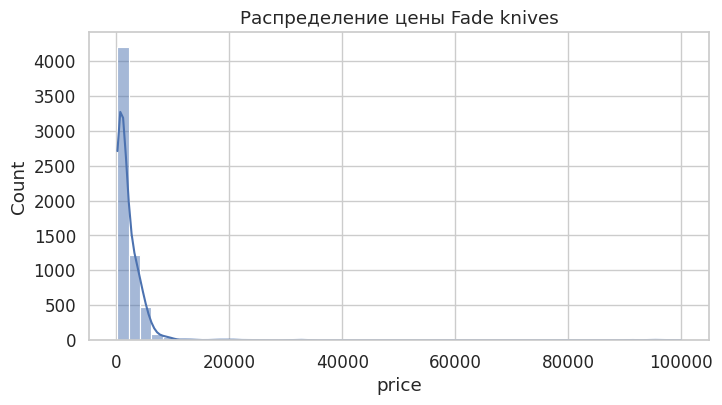

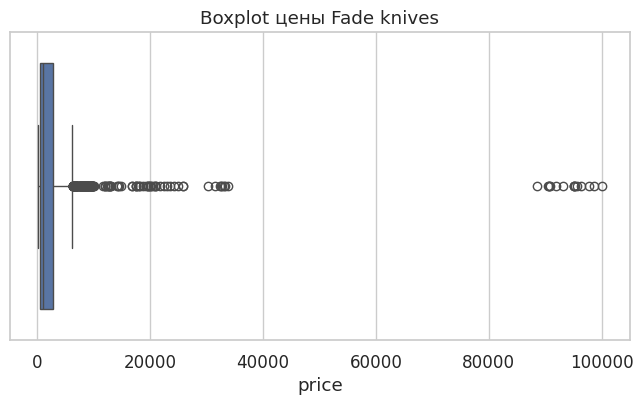

In [8]:
plt.figure(figsize=(8, 4))
sns.histplot(df[TARGET_COL], bins=50, kde=True)
plt.title("Распределение цены Fade knives")
plt.xlabel("price")
plt.show()

plt.figure(figsize=(8, 4))
sns.boxplot(x=df[TARGET_COL])
plt.title("Boxplot цены Fade knives")
plt.show()


### Распределение цен (Histogram + Boxplot)

Цены на fade-ножи имеют правостороннее распределение: основная масса предметов находится в среднем диапазоне, однако встречаются редкие дорогие экземпляры с высокими значениями `fade_percentage` и хорошими паттернами. Boxplot показывает заметное количество выбросов.

**Почему важно:**

- объясняет, почему RMSE может быть высоким из-за редких дорогих ножей;
- подтверждает наличие экстремальных значений, которые влияют на обучение;
- показывает ненормальность распределения таргета → лучше использовать нелинейные модели, такие как CatBoost.


 ## Распределение по weapon и wear

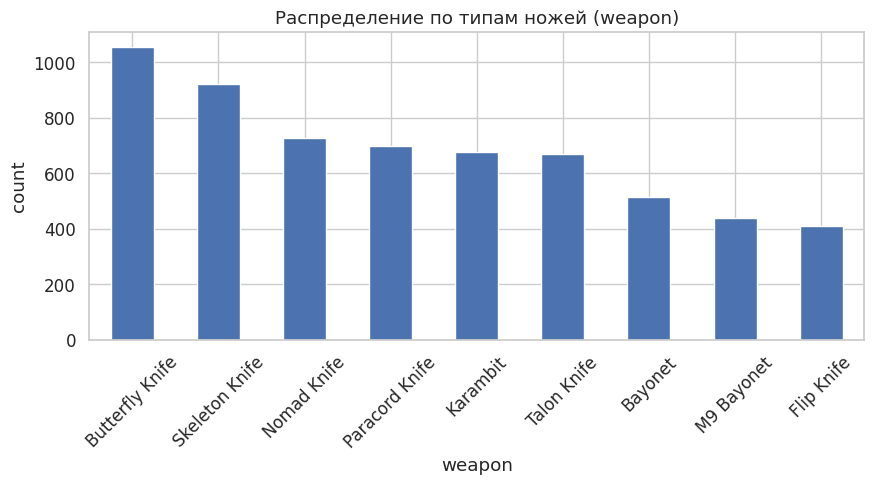

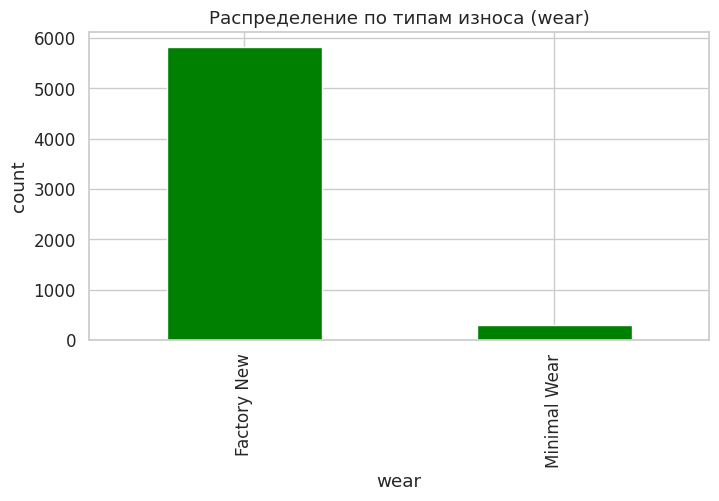

In [9]:
plt.figure(figsize=(10, 4))
df["weapon"].value_counts().plot(kind="bar")
plt.title("Распределение по типам ножей (weapon)")
plt.xlabel("weapon")
plt.ylabel("count")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(8, 4))
df["wear"].value_counts().plot(kind="bar", color="green")
plt.title("Распределение по типам износа (wear)")
plt.xlabel("wear")
plt.ylabel("count")
plt.show()

## Распределение по weapon и wear

Распределение `weapon` показывает, какие модели ножей встречаются чаще — на этих данных модель обучится лучше.  
Распределение `wear` показывает, какие состояния износа популярны на рынке (обычно Factory New и Minimal Wear доминируют для Fade-серии).

**Почему важно:**

- дисбаланс категорий по типу ножа и износу влияет на качество;
- редкие комбинации weapon + wear могут иметь повышенную ошибку предсказания.


##Распределение float, fade_percentage, fade_rank

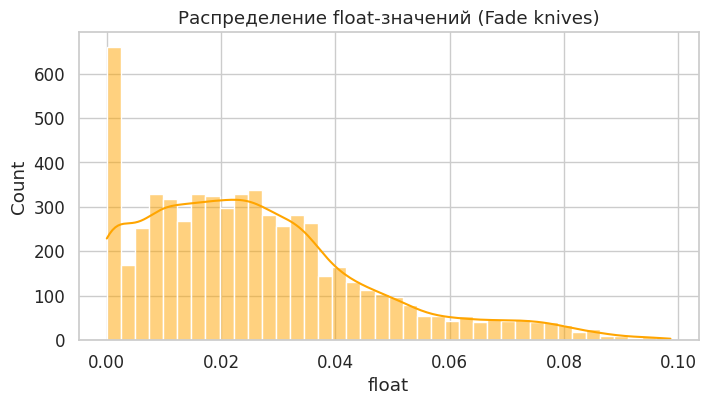

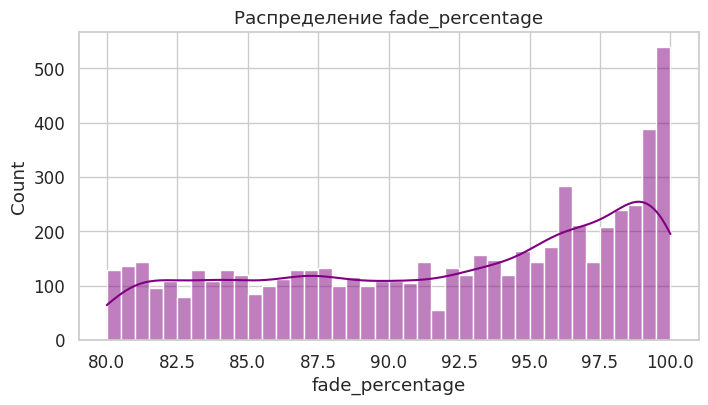

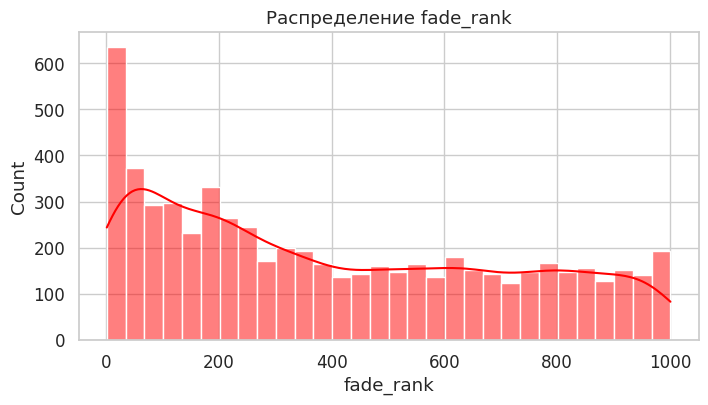

In [10]:
plt.figure(figsize=(8, 4))
sns.histplot(df["float"], bins=40, kde=True, color="orange")
plt.title("Распределение float-значений (Fade knives)")
plt.xlabel("float")
plt.show()

plt.figure(figsize=(8, 4))
sns.histplot(df["fade_percentage"], bins=40, kde=True, color="purple")
plt.title("Распределение fade_percentage")
plt.xlabel("fade_percentage")
plt.show()

plt.figure(figsize=(8, 4))
sns.histplot(df["fade_rank"], bins=30, kde=True, color="red")
plt.title("Распределение fade_rank")
plt.xlabel("fade_rank")
plt.show()

###  Распределение float, fade_percentage и fade_rank

- `float` описывает износ, но для Fade важнее визуальная часть, чем сам износ.  
- `fade_percentage` показывает, насколько высокий «процент» фейда — чем больше, тем обычно дороже.  
- `fade_rank` агрегирует качество фейда в ранговую шкалу.

**Почему важно:**

- позволяет увидеть, насколько много «идеальных» фейдов в датасете;
- показывает, есть ли достаточное количество примеров с высокими значениями fade_percentage / fade_rank;
- помогает понять, насколько эти признаки могут объяснять цену.


##Корреляционная матрица

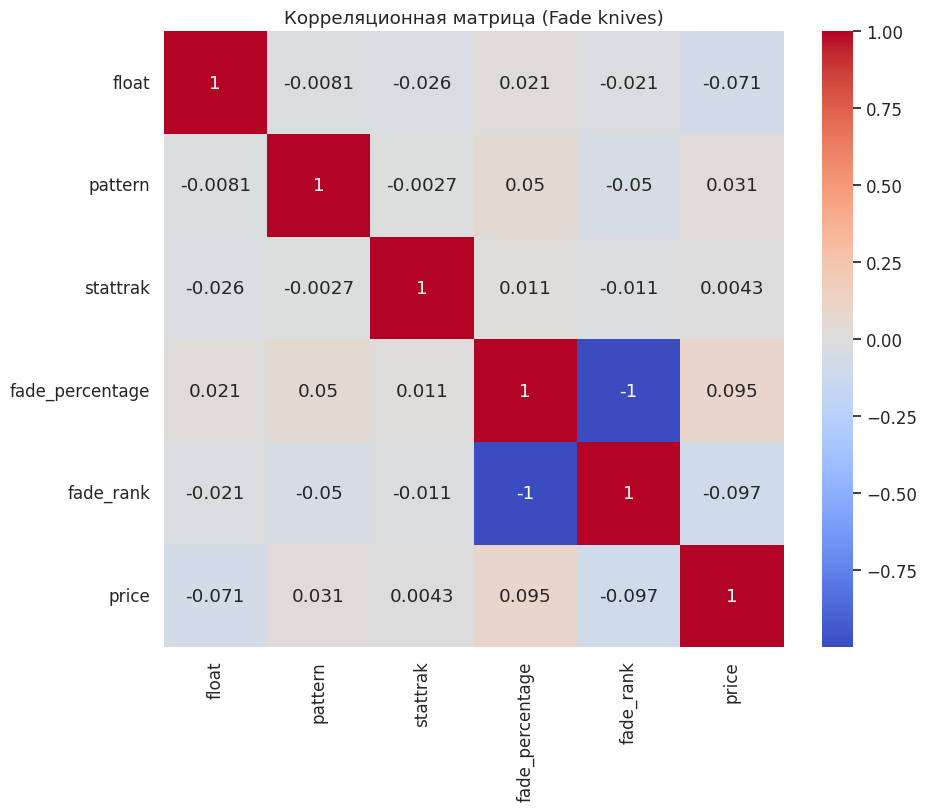

In [11]:
numeric_cols = numeric_features + [TARGET_COL]
plt.figure(figsize=(10, 8))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Корреляционная матрица (Fade knives)")
plt.show()

###Корреляционная матрица

Корреляционная матрица показывает связь между числовыми признаками (`float`, `pattern`, `fade_percentage`, `fade_rank`, `stattrak`) и ценой.

**Почему важно:**

- если `fade_percentage` и `fade_rank` заметно коррелируют с `price`, значит они действительно являются ключевыми признаками в ценообразовании;
- слабая корреляция `float` → подтверждает, что износ для Fade ножей менее критичен, чем для других скинов;
- помогает обосновать выбор признаков для модели.


##Связь float -> price

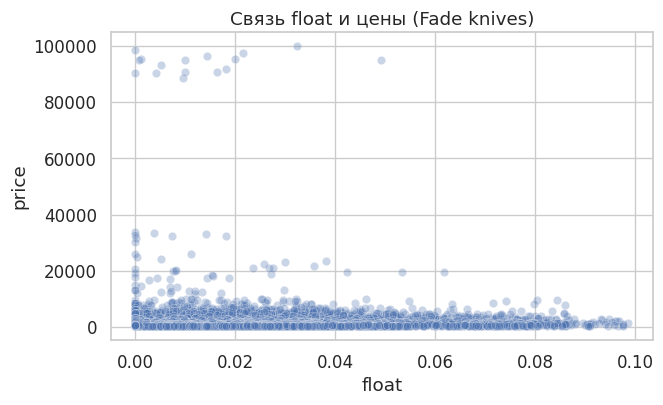

In [12]:
plt.figure(figsize=(7, 4))
sns.scatterplot(x="float", y=TARGET_COL, data=df, alpha=0.3)
plt.title("Связь float и цены (Fade knives)")
plt.xlabel("float")
plt.ylabel("price")
plt.show()

###  Связь float → price

Точечный график `float` → `price` показывает слабую или умеренную тенденцию: с ростом `float` цена слегка уменьшается, но разброс большой.

**Почему важно:**

- подтверждает, что для fade-ножей критичен не столько износ, сколько визуальное качество фейда;
- мотивирует использовать `float` как вспомогательный, а не ключевой признак.


##  Связь fade_rank → price

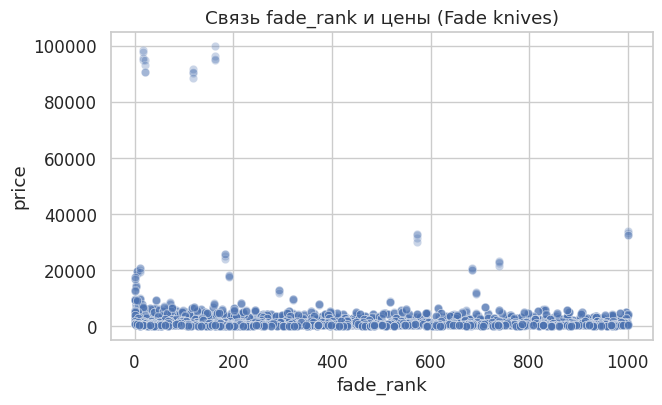

In [13]:
plt.figure(figsize=(7, 4))
sns.scatterplot(x="fade_rank", y=TARGET_COL, data=df, alpha=0.3)
plt.title("Связь fade_rank и цены (Fade knives)")
plt.xlabel("fade_rank")
plt.ylabel("price")
plt.show()

### Связь fade_rank → price

График `fade_rank` → `price` обычно показывает возрастающий тренд: ножи с более высоким рангом фейда стоят дороже.

**Почему важно:**

- демонстрирует, что engineered-признак `fade_rank` действительно полезен;
- показывает, что модель должна хорошо улавливать зависимость между визуальным качеством фейда и ценой.


 ## StatTrak -> price

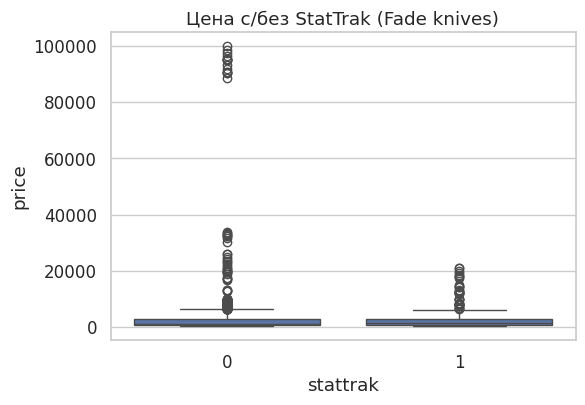

In [14]:
plt.figure(figsize=(6, 4))
sns.boxplot(x="stattrak", y=TARGET_COL, data=df)
plt.title("Цена с/без StatTrak (Fade knives)")
plt.xlabel("stattrak")
plt.ylabel("price")
plt.show()

###  StatTrak → price

Boxplot по `stattrak` показывает, что наличие StatTrak в среднем увеличивает цену, но разброс внутри классов остаётся значительным.

**Почему важно:**

- StatTrak — дополнительный мультипликативный фактор;
- модель должна учитывать эффект StatTrak, но не считать его основным драйвером стоимости.


## Средняя цена по weapon

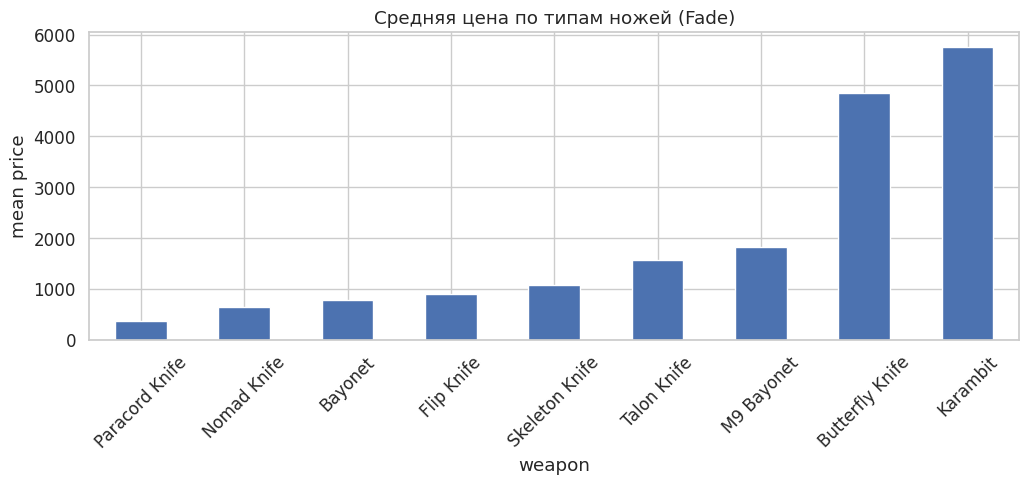

In [15]:
weapon_mean = df.groupby("weapon")[TARGET_COL].mean().sort_values()
plt.figure(figsize=(12, 4))
weapon_mean.plot(kind="bar")
plt.title("Средняя цена по типам ножей (Fade)")
plt.xlabel("weapon")
plt.ylabel("mean price")
plt.xticks(rotation=45)
plt.show()

###  Средняя цена по weapon

Средняя цена по `weapon` показывает, какие типы ножей являются более премиальными (например, Karambit, Butterfly) и изначально имеют более высокий базовый ценовой уровень.

**Почему важно:**

- `weapon` — фундаментальный категориальный признак;
- помогает модели задать «базовую линию» цены до учёта фейда, износа и других факторов.

#ML

##Препроцессинг, train/test split, пулы CatBoost

In [16]:

df_model = df[feature_cols + [TARGET_COL]].copy()
df_model = df_model.dropna(subset=[TARGET_COL])

for col in categorical_features:
    df_model[col] = df_model[col].fillna("Unknown").astype(str)

for col in numeric_features:
    df_model[col] = pd.to_numeric(df_model[col], errors="coerce")
    df_model[col] = df_model[col].fillna(df_model[col].median())

X = df_model[feature_cols]
y = df_model[TARGET_COL].astype(float)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, shuffle=True
)

print("Train size:", len(X_train))
print("Test size:", len(X_test))

cat_feature_indices = [X.columns.get_loc(c) for c in categorical_features]

train_pool = Pool(X_train, y_train, cat_features=cat_feature_indices)
test_pool  = Pool(X_test,  y_test,  cat_features=cat_feature_indices)

# Для CatBoost eval_set будем использовать test_pool
val_pool = test_pool


Train size: 4892
Test size: 1224


 ## Baseline CatBoost

In [18]:

baseline_params = {
    "depth": 8,
    "learning_rate": 0.05,
    "iterations": 1500,
    "loss_function": "RMSE",
    "eval_metric": "RMSE",
    "random_seed": RANDOM_STATE,
    "od_type": "Iter",
    "od_wait": 120,
    "verbose": False,
}

baseline_model = CatBoostRegressor(**baseline_params)
baseline_model.fit(train_pool, eval_set=val_pool, use_best_model=True)

y_pred_base = baseline_model.predict(X_test)
mae_base = mean_absolute_error(y_test, y_pred_base)
rmse_base = math.sqrt(mean_squared_error(y_test, y_pred_base))
r2_base = r2_score(y_test, y_pred_base)

print("=== Baseline CatBoost (Fade knives) ===")
print(f"MAE:  {mae_base:.2f}")
print(f"RMSE: {rmse_base:.2f}")
print(f"R²:   {r2_base:.4f}")


=== Baseline CatBoost (Fade knives) ===
MAE:  532.65
RMSE: 3129.10
R²:   0.7256


## Optuna HPO для CatBoost

In [25]:

def objective_fade(trial):
    params = {
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "iterations": trial.suggest_int("iterations", 500, 2000),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 10.0, log=True),
        "loss_function": "RMSE",
        "eval_metric": "RMSE",
        "random_seed": RANDOM_STATE,
        "od_type": "Iter",
        "od_wait": 100,
        "verbose": False,
    }

    model = CatBoostRegressor(**params)
    model.fit(train_pool, eval_set=val_pool, use_best_model=True)
    y_pred = model.predict(X_test)
    rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    return rmse

study_fade = optuna.create_study(direction="minimize")
study_fade.optimize(objective_fade, n_trials=20)

print("\n=== Optuna Results (Fade knives) ===")
print("Best params:", study_fade.best_params)
print("Best RMSE:", study_fade.best_value)

best_params_fade = study_fade.best_params.copy()
best_params_fade.update({
    "loss_function": "RMSE",
    "eval_metric": "RMSE",
    "random_seed": RANDOM_STATE,
    "od_type": "Iter",
    "od_wait": 100,
    "verbose": False,
})

tuned_model = CatBoostRegressor(**best_params_fade)
tuned_model.fit(train_pool, eval_set=val_pool, use_best_model=True)

y_pred_tuned = tuned_model.predict(X_test)
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)
rmse_tuned = math.sqrt(mean_squared_error(y_test, y_pred_tuned))
r2_tuned = r2_score(y_test, y_pred_tuned)

print("\n=== Tuned CatBoost (Optuna, Fade knives) ===")
print(f"MAE:  {mae_tuned:.2f}")
print(f"RMSE: {rmse_tuned:.2f}")
print(f"R²:   {r2_tuned:.4f}")


[I 2025-12-03 03:33:48,739] A new study created in memory with name: no-name-4aa3492a-c119-425b-a7cc-22a2984b0d84
[I 2025-12-03 03:33:57,331] Trial 0 finished with value: 3426.8576541686243 and parameters: {'depth': 8, 'learning_rate': 0.022650355935684274, 'iterations': 878, 'l2_leaf_reg': 2.68135952246562}. Best is trial 0 with value: 3426.8576541686243.
[I 2025-12-03 03:34:12,664] Trial 1 finished with value: 3197.752819424084 and parameters: {'depth': 10, 'learning_rate': 0.18399849458631842, 'iterations': 904, 'l2_leaf_reg': 0.11121198208225506}. Best is trial 1 with value: 3197.752819424084.
[I 2025-12-03 03:34:50,059] Trial 2 finished with value: 3167.7088813140995 and parameters: {'depth': 9, 'learning_rate': 0.011063525972426765, 'iterations': 1772, 'l2_leaf_reg': 0.14970649686509474}. Best is trial 2 with value: 3167.7088813140995.
[I 2025-12-03 03:34:53,162] Trial 3 finished with value: 4019.042456837118 and parameters: {'depth': 7, 'learning_rate': 0.016748251461497433, 'it


=== Optuna Results (Fade knives) ===
Best params: {'depth': 10, 'learning_rate': 0.03851120265625684, 'iterations': 1938, 'l2_leaf_reg': 0.021843066532204296}
Best RMSE: 2876.822402216907

=== Tuned CatBoost (Optuna, Fade knives) ===
MAE:  468.74
RMSE: 2876.82
R²:   0.7680


##Linear Regression + OneHot

In [26]:

preprocess_lr = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

linreg_model = Pipeline(steps=[
    ("preprocess", preprocess_lr),
    ("regressor", LinearRegression())
])

linreg_model.fit(X_train, y_train)
y_pred_lr = linreg_model.predict(X_test)

mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = math.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print("\n=== Linear Regression + OneHot (Fade knives) ===")
print(f"MAE:  {mae_lr:.2f}")
print(f"RMSE: {rmse_lr:.2f}")
print(f"R²:   {r2_lr:.4f}")



=== Linear Regression + OneHot (Fade knives) ===
MAE:  1239.98
RMSE: 5551.91
R²:   0.1361


## Сравнительная таблица моделей (Fade knives)

In [27]:

results_df = pd.DataFrame([
    {"model": "CatBoost Baseline", "MAE": mae_base, "RMSE": rmse_base, "R2": r2_base},
    {"model": "CatBoost Tuned",    "MAE": mae_tuned, "RMSE": rmse_tuned, "R2": r2_tuned},
    {"model": "Linear Regression", "MAE": mae_lr, "RMSE": rmse_lr, "R2": r2_lr},
])

print("\n=== Сравнение моделей (Fade knives) ===")
display(results_df)



=== Сравнение моделей (Fade knives) ===


,model,MAE,RMSE,R2
0,CatBoost Baseline,532.647525,3129.102378,0.725574
1,CatBoost Tuned,468.737663,2876.822402,0.768041
2,Linear Regression,1239.976869,5551.914024,0.136085


##Learning curves + Feature importance + SHAP

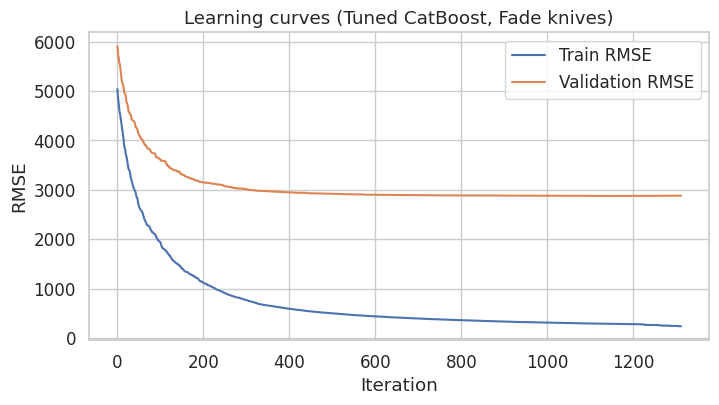


=== Важность признаков (Tuned CatBoost, Fade) ===


,feature,importance
3,fade_percentage,27.075879
4,fade_rank,24.222305
1,pattern,21.329008
5,weapon,18.178636
0,float,7.986168
2,stattrak,1.120950
7,wear,0.087054
6,skin,0.000000


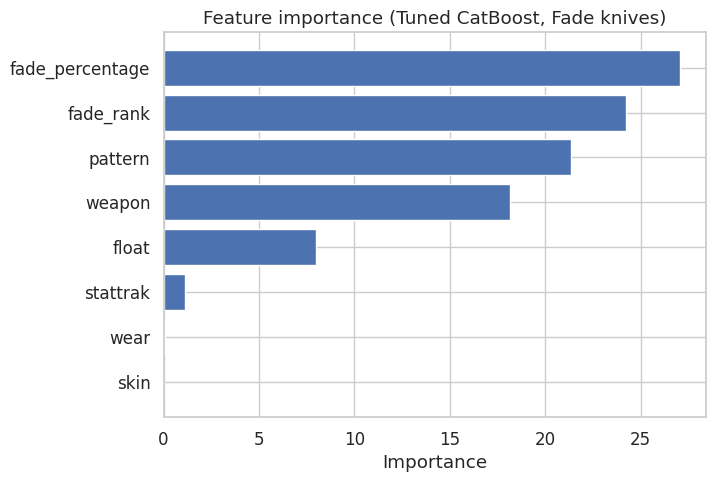


Генерируем SHAP summary plot (bar)...


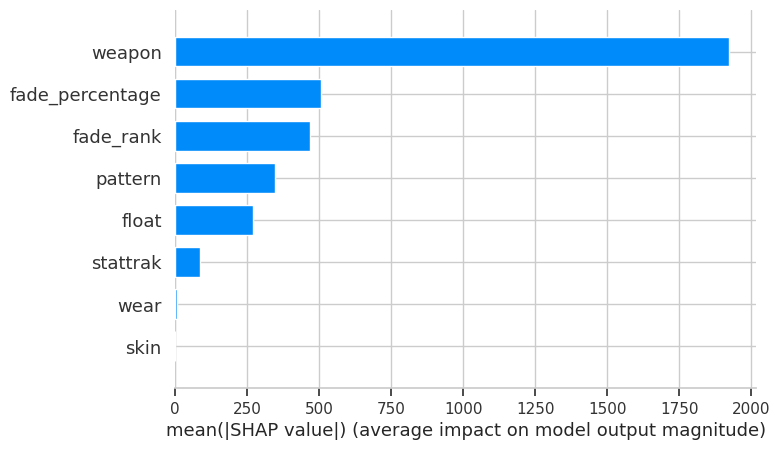


Генерируем SHAP summary plot (dot)...


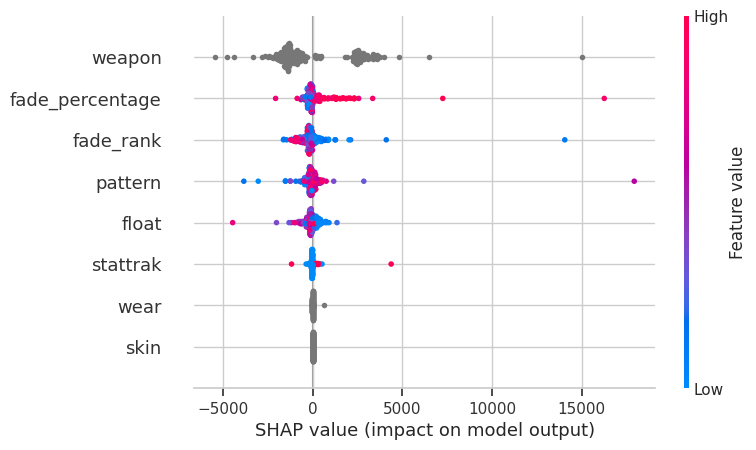

from matplotlib import pyplot as plt
fi_df['importance'].plot(kind='hist', bins=20, title='importance')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
fi_df.groupby('feature').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
fi_df['importance'].plot(kind='line', figsize=(8, 4), title='importance')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(fi_df['feature'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(fi_df, x='importance', y='feature', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [28]:

# Learning curves
evals_result = tuned_model.get_evals_result()
train_rmse = evals_result["learn"]["RMSE"]
val_rmse = evals_result["validation"]["RMSE"]

plt.figure(figsize=(8, 4))
plt.plot(train_rmse, label="Train RMSE")
plt.plot(val_rmse, label="Validation RMSE")
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.title("Learning curves (Tuned CatBoost, Fade knives)")
plt.legend()
plt.show()

# Feature importance
feat_importance_tuned = tuned_model.get_feature_importance(train_pool)
fi_df = pd.DataFrame({
    "feature": X.columns,
    "importance": feat_importance_tuned
}).sort_values("importance", ascending=False)

print("\n=== Важность признаков (Tuned CatBoost, Fade) ===")
display(fi_df)

plt.figure(figsize=(7, 5))
plt.barh(fi_df["feature"], fi_df["importance"])
plt.gca().invert_yaxis()
plt.title("Feature importance (Tuned CatBoost, Fade knives)")
plt.xlabel("Importance")
plt.show()

# SHAP
explainer = shap.TreeExplainer(tuned_model)
X_sample = X_test.sample(min(200, len(X_test)), random_state=RANDOM_STATE)
shap_values = explainer.shap_values(X_sample)

print("\nГенерируем SHAP summary plot (bar)...")
shap.summary_plot(shap_values, X_sample, plot_type="bar")
plt.show()

print("\nГенерируем SHAP summary plot (dot)...")
shap.summary_plot(shap_values, X_sample)
plt.show()


##Оптимизация инференса: Fast CatBoost + замер времени

In [29]:

def measure_inference_time(model, X, n_runs=5):
    times = []
    for _ in range(n_runs):
        start = time.time()
        _ = model.predict(X)
        end = time.time()
        times.append(end - start)
    return sum(times) / len(times)

# Быстрая CatBoost модель с меньшей глубиной и числом итераций
fast_model = CatBoostRegressor(
    depth=6,
    learning_rate=0.1,
    iterations=400,
    loss_function="RMSE",
    eval_metric="RMSE",
    random_seed=RANDOM_STATE,
    od_type="Iter",
    od_wait=50,
    verbose=False,
)

fast_model.fit(train_pool, eval_set=val_pool, use_best_model=True)
y_pred_fast = fast_model.predict(X_test)

mae_fast = mean_absolute_error(y_test, y_pred_fast)
rmse_fast = math.sqrt(mean_squared_error(y_test, y_pred_fast))
r2_fast = r2_score(y_test, y_pred_fast)

time_base = measure_inference_time(baseline_model, X_test)
time_tuned = measure_inference_time(tuned_model, X_test)
time_fast = measure_inference_time(fast_model, X_test)
time_lr   = measure_inference_time(linreg_model, X_test)

print("\n=== Fast CatBoost (Fade knives) ===")
print(f"MAE:  {mae_fast:.2f}")
print(f"RMSE: {rmse_fast:.2f}")
print(f"R²:   {r2_fast:.4f}")

print("\n=== Время inference (секунд на весь X_test, усреднённо) ===")
print(f"CatBoost Baseline: {time_base:.4f} s")
print(f"CatBoost Tuned:    {time_tuned:.4f} s")
print(f"Fast CatBoost:     {time_fast:.4f} s")
print(f"Linear Regression: {time_lr:.4f} s")



=== Fast CatBoost (Fade knives) ===
MAE:  646.18
RMSE: 3150.88
R²:   0.7217

=== Время inference (секунд на весь X_test, усреднённо) ===
CatBoost Baseline: 0.0067 s
CatBoost Tuned:    0.0119 s
Fast CatBoost:     0.0035 s
Linear Regression: 0.0050 s


# W&B: логирование нескольких моделей

In [30]:

wandb.login()

def train_and_log_catboost_fade(run_name: str, params: dict):
    with wandb.init(
        project="cs2-fade-knives-pricing",
        name=run_name,
        config=params
    ):
        model = CatBoostRegressor(**params)
        model.fit(train_pool, eval_set=val_pool, use_best_model=True, verbose=False)

        y_pred = model.predict(test_pool)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = math.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        wandb.log({"MAE": mae, "RMSE": rmse, "R2": r2})

        evals_result = model.get_evals_result()
        train_rmse = evals_result["learn"]["RMSE"]
        val_rmse = evals_result["validation"]["RMSE"]

        for step, (tr, va) in enumerate(zip(train_rmse, val_rmse), start=1):
            wandb.log({"RMSE/train": tr, "RMSE/val": va}, step=step)

        # feature importance
        feat_importances = model.get_feature_importance(train_pool)
        fi_df = pd.DataFrame({
            "feature": X.columns,
            "importance": feat_importances
        }).sort_values("importance", ascending=False)

        plt.figure(figsize=(7, 5))
        plt.barh(fi_df["feature"], fi_df["importance"])
        plt.gca().invert_yaxis()
        plt.title(f"Feature Importance ({run_name})")
        plt.xlabel("Importance")
        wandb.log({"Feature Importance": wandb.Image(plt)})
        plt.close()

        return model

def train_and_log_linreg_fade(run_name: str):
    preprocess = ColumnTransformer(
        transformers=[
            ("num", "passthrough", numeric_features),
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ]
    )
    model = Pipeline(steps=[
        ("preprocess", preprocess),
        ("regressor", LinearRegression())
    ])

    with wandb.init(
        project="cs2-fade-knives-pricing",
        name=run_name,
        config={
            "model_type": "LinearRegression",
            "numeric_features": numeric_features,
            "categorical_features": categorical_features,
        }
    ):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mae = mean_absolute_error(y_test, y_pred)
        rmse = math.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        wandb.log({"MAE": mae, "RMSE": rmse, "R2": r2})

    return model

# Берём те же параметры, что использовали выше
cb_baseline_wb = train_and_log_catboost_fade("fade_catboost_baseline", baseline_params)
cb_tuned_wb    = train_and_log_catboost_fade("fade_catboost_tuned", best_params_fade)
lr_wb          = train_and_log_linreg_fade("fade_linear_regression")


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: 20220481 (20220481-https-en-ehuniversity-lt-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


MAE,▁
R2,▁
RMSE,▁
RMSE/train,█▆▆▅▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
RMSE/val,█▄▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAE,532.64752
R2,0.72557
RMSE,3129.10238
RMSE/train,437.77379
RMSE/val,3129.10235


MAE,▁
R2,▁
RMSE,▁
RMSE/train,█▇▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
RMSE/val,█▇▇▄▄▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAE,468.73766
R2,0.76804
RMSE,2876.8224
RMSE/train,241.14158
RMSE/val,2883.64235


MAE,▁
R2,▁
RMSE,▁
MAE,1239.97687
R2,0.13608
RMSE,5551.91402
